In [1]:
import numpy as np
import nltk
import os
import string 
import pickle
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from num2words import num2words
from tqdm import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
import math
import heapq
import re
import pandas as pd
from unidecode import unidecode
from sklearn.manifold import TSNE

In [2]:
ps = PorterStemmer()

In [3]:
path = 'C:\\Users\\shekh\\Desktop\\Shekhar\\IR\\Assignment 1\\20_newsgroups'
folders = []
files = []
docs = []
names = []

#loading folders
for folder in os.listdir(path):
    folders.append(folder)
    
#print(folders)

subset = ['comp.graphics', 'sci.med','talk.politics.misc', 'rec.sport.hockey', 'sci.space']

docsdic = {}

#loading files from each folder 
for folder in folders:
    if folder in subset:
        newpath = path +'\\'+folder
        for file in tqdm(os.listdir(newpath)):
            try:
                f = open(newpath+'\\'+file,"r")
                #print(doc)
                doc = f.read()
                #adding files to list
                docs.append(doc)
                if folder in docsdic:
                    docsdic[folder].append(file)
                else:
                    docsdic[folder] = [file]
                names.append((file,folder))
                f.close()
            except:
                pass
            
      

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 543.26it/s]


In [4]:
#print(docsdic)

In [5]:
def listtodict(keys, values):
    keys = keys.copy()
    values = values.copy()
    dic = {}
    for key in range(len(keys)): 
        for value in values: 
            dic[key] = value
            values.remove(value)
            break  
    return dic

In [6]:
def remove_metadata(documents):
    pos = documents.index('\n\n')
    fixed_docs = documents[pos:]
    return fixed_docs

In [7]:
def apply_proter_stemmer(string):
    for i in range(len(string)):
        string[i] = ps.stem(string[i])
    return string
        

In [8]:
def remove_stopword(string):
    stop_words = set(stopwords.words('english'))
    data = [w for w in string if not w in stop_words]
    return data

In [9]:
def convert_num(string):
    for i in range(len(string)):
        try:
            if(string[i].isnumeric()):
                string[i] = num2words(string[i])
        except:
            continue
    return string

In [10]:
def remove_nonascii(string):
    stripped = (c for c in string if 0 < ord(c) < 127)
    return ''.join(stripped)

In [11]:
def preprocessing(newdataset):
    dataset = newdataset.copy()
    for i in tqdm(range(len(dataset))):
        dataset[i] = dataset[i].lower()
        dataset[i] = remove_nonascii(dataset[i])
        dataset[i] = dataset[i].translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
        dataset[i] = dataset[i].split()
        dataset[i] = remove_stopword(dataset[i])
        dataset[i] = convert_num(dataset[i])
        dataset[i] = apply_proter_stemmer(dataset[i])
    return dataset

In [12]:
def querypreprocessing(stringdata):
    lower = stringdata.lower()
    punc = lower.translate(str.maketrans('','',string.punctuation))
    spl = punc.split()
    removestop = remove_stopword(spl)
    removenum = convert_num(removestop)
    stemmedquery = apply_proter_stemmer(removenum)
    
    for word in stemmedquery:
        if word not in vocab:
            stemmedquery.remove(word)
    
    return stemmedquery

In [13]:
def create_vocabulary(data):
    vocab = set()
    for doc in data:
        for word in doc:
            #print(word)
            vocab.add(word)
    return list(vocab)

In [14]:
def termfreq(data, word):
    if data.count(word) == 0:
        return 0.0
    else:
        return 1+(math.log10(data.count(word)))
        #return(data.count(word)/len(data))

In [15]:
def create_dataframe(vocab, data):
    df = pd.DataFrame()
    df['vocab'] = vocab
    
    
    tfall = []
    
    for i in tqdm(range(len(data))):
        tf1 = []
        for word in vocab:
            tf1.append(termfreq(data[i],word))
        #print(len(tf1))
        tfall.append(tf1)
    #print(tfall)
    
    for i in tqdm(range(len(tfall))):
        df.insert(i+1, i, tfall[i],allow_duplicates = False)
    
    df.set_index('vocab', inplace = True)
    
    nonzero = np.count_nonzero(df,axis = 1) 
    
    #print("non zero",len(nonzero))
    
    idf = []
    for i in tqdm(range(len(nonzero))):
        #print(nonzero[i])
        idf.append(1/(1+(math.log10(df.shape[1]/nonzero[i]))))
    
    df['idf'] = idf
    return df

In [16]:
def cosine_similarity(vec1, vec2):
    if np.isnan(np.dot(vec1, vec2)/(math.sqrt(np.sum(np.square(vec1)))*math.sqrt(np.sum(np.square(vec2))))):
        return 0
    else:
        return np.dot(vec1, vec2)/(math.sqrt(np.sum(np.square(vec1)))*math.sqrt(np.sum(np.square(vec2))))

In [17]:
def create_tfidf(df1):
    df = df1.copy()
    df.iloc[:, 0:-1] = df.iloc[:, 0:-1].mul(df.iloc[:, -1], axis=0)
    #print(df)
    return df

In [18]:
idtoname = listtodict(docs, names)

In [19]:
#nametoid = listtodict(names, docs)

In [20]:
print(idtoname[0])

('37261', 'comp.graphics')


In [21]:
print(type(names[0][0]))

<class 'str'>


In [22]:
nametoid = {}
for i in range(len(names)):
    nametoid[names[i][0]] = i

In [23]:
print(type(nametoid['37261']))

<class 'int'>


In [24]:
def cosine_retrieval(df1, querytfidf, vocabulary):
    
    df = df1.copy()
    
    
    #for i in querytfidf:
     #   if i > 0:
      #      print("queryvector",i)
    
    df = df.drop(labels = 'idf', axis = 1)
    #print(df.shape[1])
    #print(len(queryvector))
    similarity = []
    
    for i in range(df.shape[1]):
        val = df.iloc[:,i].values
        similarity.append(cosine_similarity(querytfidf, val))
    
    nonzero = []
    
    for i in similarity:
        if i > 0:
            nonzero.append(i)
    #print(nonzero)
    nonzero.sort(reverse=True)
    result = []
    #print(similarity)
    
    for i in nonzero:
        result.append(similarity.index(i))
        
    return result

In [25]:
def create_query_vector(query, df1, vocabulary):
    df = df1.copy()
    
    processedquery = querypreprocessing(query)
    
    for word in processedquery:
        if word not in vocabulary:
            processedquery.remove(word)
    
    #print(processedquery.count("cindi")/len(processedquery))
    queryvector = np.zeros((df.shape[0]))
    #print(len(queryvector))
    wordvector = df.index.values 
    
    for i in range(len(wordvector)):
        for word in processedquery:
            if wordvector[i] == word:
                #print(wordvector[i], word)
                #print(processedquery.count(word)/len(processedquery))
                queryvector[i] = processedquery.count(word)/len(processedquery)
                #print(queryvector[i],i)
        
    
    idf = df.iloc[:,-1].values 
    #print("len of idf",len(idf))
    #print(queryvector)
    #print("len of query vector",len(queryvector))
    querytfidf = np.multiply(queryvector,idf)
    #print("length of query tfidf",len(querytfidf))
    
    return querytfidf
    

In [26]:
for i in range(len(docs)):
    docs[i] = remove_metadata(docs[i])

In [27]:
processed_data = preprocessing(docs)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:02<00:00, 79.42it/s]


In [28]:
vocab = create_vocabulary(processed_data)

In [29]:
print(len(vocab))

41701


Be patient it take about 10min

In [30]:
inverted_index = create_dataframe(vocab, processed_data)

100%|████████████████████████████████████████████████████████████████████████| 41701/41701 [00:00<00:00, 386029.04it/s]


### Question 1
the dataframe consists of all the tdidf values for each term for each document 

In [32]:
tf_idf_invertedindex = create_tfidf(inverted_index)

In [33]:
print(tf_idf_invertedindex.shape)

(41701, 5001)


In [34]:
#tf_idf_invertedindex.to_csv("tf_idf_invertedindex.csv", index = True)

In [35]:
def rocchio_feedback(queryvec, reldocs, nonreldocs, df1):
    dataframe = df1.copy()
    modified_query_vector = 1*queryvec + (0.75*(dataframe[reldocs].sum(axis = 1)/len(reldocs))) - (0.25*(dataframe[nonreldocs].sum(axis = 1)/len(nonreldocs))) 
    
    for i in range(len(modified_query_vector)):
        if modified_query_vector[i] < 0:
            modified_query_vector[i] = 0
    
    return modified_query_vector

In [36]:
def plot_pr(relevantfolder, alldata):
    
    retrievedres = []
    
    for i in range(len(alldata)):
        retrievedres.append(idtoname[alldata[i]][0])
    
    #print(retrievedres)
    
    relevant = docsdic[relevantfolder]
    #print(len(relevant))
    precision = []
    pmap = []
    recall = []
    retrieved = 0
    tp = 0
    

    for i in range(len(retrievedres)):
        if retrievedres[i] in relevant:
            tp += 1
        retrieved += 1
        #print(retrieved)
    
        precision.append(tp/retrieved)
        recall.append(tp/len(relevant))
    
    for i in range(len(retrievedres)):
        if retrievedres[i] in relevant:
            pmap.append(precision[i])
    
    avgpre = sum(pmap)
    MAP = avgpre/len(pmap)
    
    
    
    import matplotlib.pyplot as plt
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('precision-recall curve')
    plt.plot(recall, precision)
    plt.show()
    
    return MAP
#print(relevant)

In [37]:
def tsne_plot(reldocs, irreldocs, df1, query_vector):
    dataframe = df1.copy()
    
    labels = np.append(np.zeros(len(reldocs)),np.ones(len(irreldocs)))
    labels = np.append(labels, 2)
    labels =  labels.astype(int)    
    
    
    data = dataframe.loc[:,reldocs+irreldocs].values
    data = np.column_stack((data, query_vector))
    data = data.transpose()
    
    #print(data)
    
    tsne = np.array(TSNE(n_components = 2, random_state = 0).fit_transform(data))
    
    #print(tsne)
    
    colormap = np.array(['tab:blue', 'tab:orange', 'tab:green'])
    groups = np.array(["R", "N-R", "Query"])
    
    
    plt.scatter(tsne[:,0], tsne[:,1], alpha=0.8,s=50,c=colormap[labels], label = groups)
    plt.legend()
    plt.title("Rocchio Algorithm")
    plt.show()
    print("Blue: Relevant, Orange: Irrelevant, Green: Query")

In [38]:
#tsne_plot(reldocs, irrdocs, tf_idf_invertedindex, query_vector)

### Question 2

Enter Query: Pretty good opinions on biochemistry machines
Enter value of K: 100
give number of iteration for feedback 4


c:\users\shekh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0 .  ('59429', 'sci.med')
1 .  ('53848', 'rec.sport.hockey')
2 .  ('61084', 'sci.space')
3 .  ('59564', 'sci.med')
4 .  ('58087', 'sci.med')
5 .  ('59393', 'sci.med')
6 .  ('38759', 'comp.graphics')
7 .  ('53791', 'rec.sport.hockey')
8 .  ('54242', 'rec.sport.hockey')
9 .  ('59389', 'sci.med')
10 .  ('61183', 'sci.space')
11 .  ('53995', 'rec.sport.hockey')
12 .  ('53998', 'rec.sport.hockey')
13 .  ('38240', 'comp.graphics')
14 .  ('54753', 'rec.sport.hockey')
15 .  ('62386', 'sci.space')
16 .  ('39052', 'comp.graphics')
17 .  ('38742', 'comp.graphics')
18 .  ('53913', 'rec.sport.hockey')
19 .  ('62708', 'sci.space')
20 .  ('38523', 'comp.graphics')
21 .  ('38604', 'comp.graphics')
22 .  ('38629', 'comp.graphics')
23 .  ('38372', 'comp.graphics')
24 .  ('53564', 'rec.sport.hockey')
25 .  ('38869', 'comp.graphics')
26 .  ('38943', 'comp.graphics')
27 .  ('38588', 'comp.graphics')
28 .  ('58819', 'sci.med')
29 .  ('176902', 'talk.politics.misc')
30 .  ('61454', 'sci.space')
31 .  ('17848

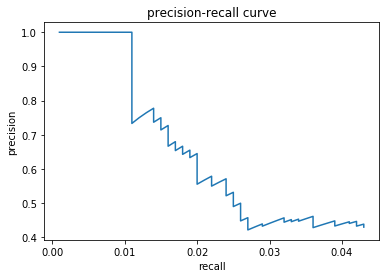

MAP:  0.658620345835331


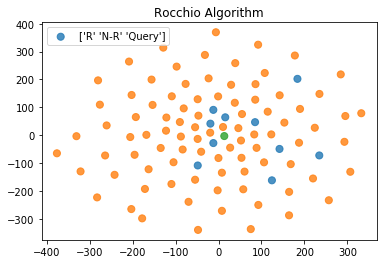

Blue: Relevant, Orange: Irrelevant, Green: Query
Iteration:  2
Enter index of relevant docs separated by space 7 8 10 16 17 19 21 24 26 28


c:\users\shekh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0 .  ('59499', 'sci.med') *
1 .  ('59234', 'sci.med') *
2 .  ('58155', 'sci.med') *
3 .  ('59459', 'sci.med') *
4 .  ('59553', 'sci.med') *
5 .  ('59255', 'sci.med')
6 .  ('58065', 'sci.med') *
7 .  ('59189', 'sci.med')
8 .  ('59303', 'sci.med') *
9 .  ('59183', 'sci.med')
10 .  ('59219', 'sci.med') *
11 .  ('59488', 'sci.med')
12 .  ('59256', 'sci.med')
13 .  ('178571', 'talk.politics.misc')
14 .  ('59632', 'sci.med')
15 .  ('59637', 'sci.med')
16 .  ('177004', 'talk.politics.misc')
17 .  ('59490', 'sci.med')
18 .  ('59069', 'sci.med')
19 .  ('59454', 'sci.med') *
20 .  ('178293', 'talk.politics.misc')
21 .  ('59548', 'sci.med')
22 .  ('58123', 'sci.med')
23 .  ('59432', 'sci.med')
24 .  ('58578', 'sci.med')
25 .  ('178724', 'talk.politics.misc')
26 .  ('38403', 'comp.graphics')
27 .  ('39078', 'comp.graphics')
28 .  ('39638', 'comp.graphics')
29 .  ('178786', 'talk.politics.misc')
30 .  ('178914', 'talk.politics.misc')
31 .  ('59165', 'sci.med')
32 .  ('58109', 'sci.med')
33 .  ('593

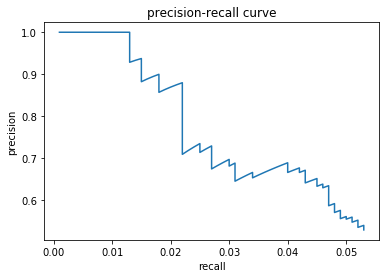

MAP:  0.7820343897877785


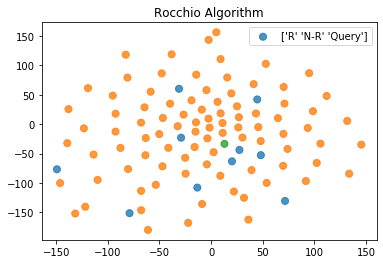

Blue: Relevant, Orange: Irrelevant, Green: Query
Iteration:  3
Enter index of relevant docs separated by space 52 53 53 55 56 57 60 61 63 67


c:\users\shekh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0 .  ('59499', 'sci.med')
1 .  ('59183', 'sci.med')
2 .  ('59234', 'sci.med')
3 .  ('59333', 'sci.med') *
4 .  ('59459', 'sci.med')
5 .  ('58155', 'sci.med')
6 .  ('59304', 'sci.med')
7 .  ('59303', 'sci.med')
8 .  ('59332', 'sci.med') *
9 .  ('58910', 'sci.med') *
10 .  ('58984', 'sci.med') *
11 .  ('59031', 'sci.med') *
12 .  ('59219', 'sci.med')
13 .  ('59395', 'sci.med')
14 .  ('59207', 'sci.med') *
15 .  ('59209', 'sci.med') *
16 .  ('59255', 'sci.med')
17 .  ('59222', 'sci.med') *
18 .  ('58953', 'sci.med') *
19 .  ('59256', 'sci.med')
20 .  ('59322', 'sci.med')
21 .  ('59553', 'sci.med')
22 .  ('59165', 'sci.med')
23 .  ('59490', 'sci.med')
24 .  ('59488', 'sci.med')
25 .  ('59069', 'sci.med')
26 .  ('59632', 'sci.med')
27 .  ('59189', 'sci.med')
28 .  ('58065', 'sci.med')
29 .  ('59548', 'sci.med')
30 .  ('59554', 'sci.med')
31 .  ('59637', 'sci.med')
32 .  ('178571', 'talk.politics.misc')
33 .  ('59338', 'sci.med')
34 .  ('58897', 'sci.med')
35 .  ('59318', 'sci.med')
36 .  ('

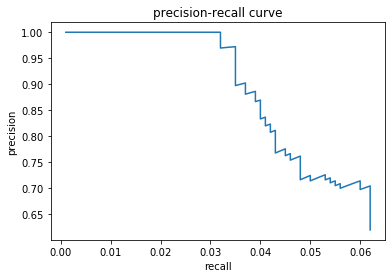

MAP:  0.897727695955912


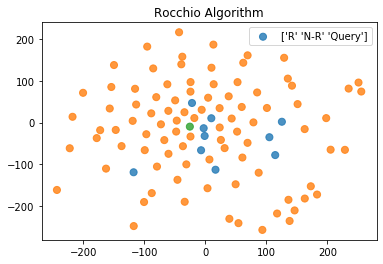

Blue: Relevant, Orange: Irrelevant, Green: Query
Iteration:  4
Enter index of relevant docs separated by space 19 20 21 22 23 24 25 26 27 28


c:\users\shekh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0 .  ('59183', 'sci.med')
1 .  ('59499', 'sci.med')
2 .  ('59165', 'sci.med') *
3 .  ('59488', 'sci.med') *
4 .  ('59333', 'sci.med')
5 .  ('59234', 'sci.med')
6 .  ('59256', 'sci.med') *
7 .  ('59632', 'sci.med') *
8 .  ('59069', 'sci.med') *
9 .  ('59304', 'sci.med')
10 .  ('59490', 'sci.med') *
11 .  ('59322', 'sci.med') *
12 .  ('59049', 'sci.med')
13 .  ('59332', 'sci.med')
14 .  ('59459', 'sci.med')
15 .  ('58155', 'sci.med')
16 .  ('59553', 'sci.med') *
17 .  ('59189', 'sci.med') *
18 .  ('59554', 'sci.med')
19 .  ('59395', 'sci.med')
20 .  ('58910', 'sci.med')
21 .  ('59548', 'sci.med')
22 .  ('58065', 'sci.med') *
23 .  ('58984', 'sci.med')
24 .  ('59207', 'sci.med')
25 .  ('59637', 'sci.med')
26 .  ('59255', 'sci.med')
27 .  ('59303', 'sci.med')
28 .  ('59034', 'sci.med')
29 .  ('59338', 'sci.med')
30 .  ('178571', 'talk.politics.misc')
31 .  ('178786', 'talk.politics.misc')
32 .  ('178293', 'talk.politics.misc')
33 .  ('58578', 'sci.med')
34 .  ('58953', 'sci.med')
35 .  ('5

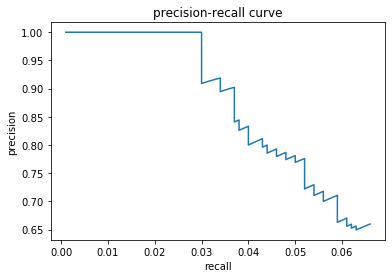

MAP:  0.8785603656269405


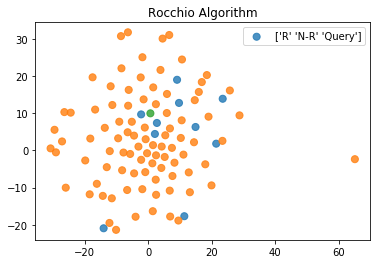

Blue: Relevant, Orange: Irrelevant, Green: Query


In [39]:

query = input("Enter Query: ")
k = int(input("Enter value of K: "))
feed_back_iteration = int(input("give number of iteration for feedback "))
query_vector = create_query_vector(query, tf_idf_invertedindex, vocab)
result_cosine = cosine_retrieval(tf_idf_invertedindex, query_vector, vocab)

kdocs = result_cosine[:k]
MAP = []
for i in range(int(k)):
        print(i,". ",idtoname[kdocs[i]])
        
for i in range(feed_back_iteration):
    print("Iteration: ",i+1)
    kdocs = result_cosine[:k]

    relevantinput = input("Enter index of relevant docs separated by space ")
    relevant_docs_input = relevantinput.split()

    relevant_docs_input = [int(i) for i in relevant_docs_input] 
        
    feedbackdf = tf_idf_invertedindex.loc[:,kdocs]

    reldocs = []
    irrdocs = []
    MAPi = [] 
    for i in relevant_docs_input:
        reldocs.append(kdocs[i])
    for i in kdocs:
        if i not in reldocs:
            irrdocs.append(i)

    query_vector = rocchio_feedback(query_vector,reldocs,irrdocs,feedbackdf)
    result_cosine = cosine_retrieval(tf_idf_invertedindex, query_vector, vocab)
    
    kdocs = result_cosine[:k]
    
    for i in range(int(k)):
        if kdocs[i] in reldocs:
            print(i,". ",idtoname[kdocs[i]], "*")
        else:
            print(i,". ",idtoname[kdocs[i]])

    mapi = plot_pr("sci.med",kdocs)
    MAPi.append(mapi)
    print("MAP: ",mapi)
    tsne_plot(reldocs, irrdocs, tf_idf_invertedindex, query_vector)
MAP.append(MAPi)

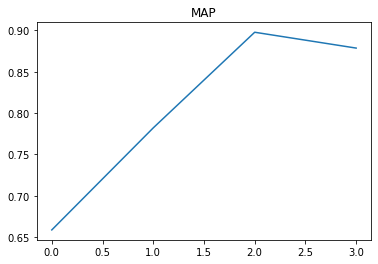

taking avg of above shown map
MAP 0.8042356993014905


In [13]:
map1 = [ 0.658620345835331,0.7820343897877785,0.897727695955912,0.8785603656269405 ]
plt.plot(map1)
plt.title("MAP")
plt.show()
avgmap1 = sum(map1)/len(map1)
print("taking avg of above shown map")
print("MAP",avgmap1)

Enter Query: Scientific tools for preserving rights and body
Enter value of K: 100
give number of iteration for feedback 4


c:\users\shekh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0 .  ('60876', 'sci.space')
1 .  ('59386', 'sci.med')
2 .  ('179045', 'talk.politics.misc')
3 .  ('60851', 'sci.space')
4 .  ('61307', 'sci.space')
5 .  ('61145', 'sci.space')
6 .  ('177014', 'talk.politics.misc')
7 .  ('61226', 'sci.space')
8 .  ('60931', 'sci.space')
9 .  ('61094', 'sci.space')
10 .  ('61278', 'sci.space')
11 .  ('61350', 'sci.space')
12 .  ('178616', 'talk.politics.misc')
13 .  ('176858', 'talk.politics.misc')
14 .  ('178384', 'talk.politics.misc')
15 .  ('61357', 'sci.space')
16 .  ('61257', 'sci.space')
17 .  ('178409', 'talk.politics.misc')
18 .  ('61116', 'sci.space')
19 .  ('59051', 'sci.med')
20 .  ('61319', 'sci.space')
21 .  ('39015', 'comp.graphics')
22 .  ('38388', 'comp.graphics')
23 .  ('61532', 'sci.space')
24 .  ('58978', 'sci.med')
25 .  ('58967', 'sci.med')
26 .  ('61273', 'sci.space')
27 .  ('61475', 'sci.space')
28 .  ('60830', 'sci.space')
29 .  ('61168', 'sci.space')
30 .  ('60994', 'sci.space')
31 .  ('58993', 'sci.med')
32 .  ('52669', 'rec.spo

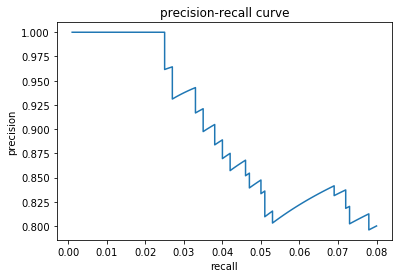

MAP:  0.9012420912065535


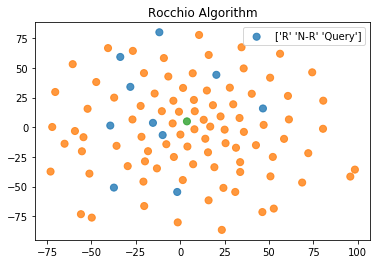

Blue: Relevant, Orange: Irrelevant, Green: Query
Iteration:  2
Enter index of relevant docs separated by space 11 12 13 14 15 16 17 18 19 20


c:\users\shekh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0 .  ('178724', 'talk.politics.misc') *
1 .  ('176970', 'talk.politics.misc') *
2 .  ('177020', 'talk.politics.misc') *
3 .  ('179027', 'talk.politics.misc') *
4 .  ('176905', 'talk.politics.misc') *
5 .  ('178776', 'talk.politics.misc')
6 .  ('178304', 'talk.politics.misc') *
7 .  ('178382', 'talk.politics.misc')
8 .  ('178865', 'talk.politics.misc')
9 .  ('177021', 'talk.politics.misc')
10 .  ('178688', 'talk.politics.misc')
11 .  ('176849', 'talk.politics.misc') *
12 .  ('176995', 'talk.politics.misc')
13 .  ('179058', 'talk.politics.misc')
14 .  ('178571', 'talk.politics.misc')
15 .  ('61299', 'sci.space')
16 .  ('59183', 'sci.med')
17 .  ('179028', 'talk.politics.misc')
18 .  ('179107', 'talk.politics.misc') *
19 .  ('179029', 'talk.politics.misc')
20 .  ('176957', 'talk.politics.misc')
21 .  ('178869', 'talk.politics.misc')
22 .  ('178894', 'talk.politics.misc')
23 .  ('179031', 'talk.politics.misc')
24 .  ('178417', 'talk.politics.misc')
25 .  ('176993', 'talk.politics.misc')
26

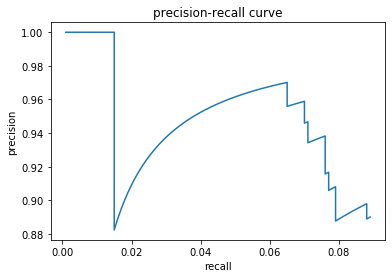

MAP:  0.9481199717053583


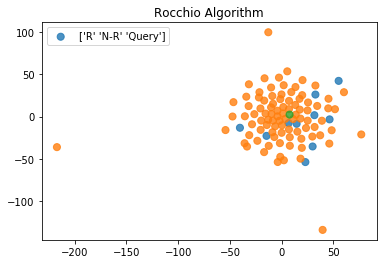

Blue: Relevant, Orange: Irrelevant, Green: Query
Iteration:  3
Enter index of relevant docs separated by space 44 45 46 47 48 89 90 91 92 93


c:\users\shekh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0 .  ('178724', 'talk.politics.misc')
1 .  ('176970', 'talk.politics.misc')
2 .  ('178293', 'talk.politics.misc') *
3 .  ('178672', 'talk.politics.misc') *
4 .  ('178430', 'talk.politics.misc') *
5 .  ('178382', 'talk.politics.misc')
6 .  ('179058', 'talk.politics.misc')
7 .  ('178865', 'talk.politics.misc')
8 .  ('177020', 'talk.politics.misc')
9 .  ('178571', 'talk.politics.misc')
10 .  ('178776', 'talk.politics.misc')
11 .  ('179027', 'talk.politics.misc')
12 .  ('178313', 'talk.politics.misc')
13 .  ('179033', 'talk.politics.misc')
14 .  ('178786', 'talk.politics.misc')
15 .  ('176905', 'talk.politics.misc')
16 .  ('178911', 'talk.politics.misc') *
17 .  ('178587', 'talk.politics.misc') *
18 .  ('59183', 'sci.med')
19 .  ('178688', 'talk.politics.misc')
20 .  ('178769', 'talk.politics.misc') *
21 .  ('179029', 'talk.politics.misc')
22 .  ('179073', 'talk.politics.misc')
23 .  ('178894', 'talk.politics.misc')
24 .  ('179030', 'talk.politics.misc') *
25 .  ('178908', 'talk.politics.m

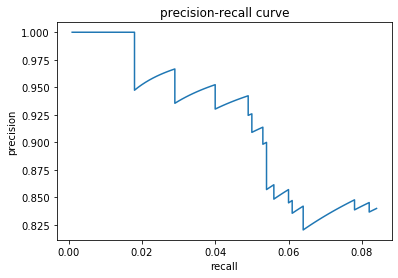

MAP:  0.9191527208088589


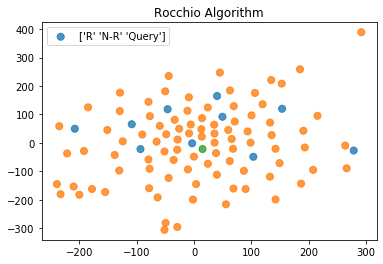

Blue: Relevant, Orange: Irrelevant, Green: Query
Iteration:  4
Enter index of relevant docs separated by space 4 31 32 34 78 79 80 94 95 96


c:\users\shekh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0 .  ('178724', 'talk.politics.misc')
1 .  ('178293', 'talk.politics.misc')
2 .  ('176960', 'talk.politics.misc') *
3 .  ('179058', 'talk.politics.misc')
4 .  ('176970', 'talk.politics.misc')
5 .  ('178547', 'talk.politics.misc') *
6 .  ('178571', 'talk.politics.misc')
7 .  ('178382', 'talk.politics.misc')
8 .  ('179073', 'talk.politics.misc')
9 .  ('178672', 'talk.politics.misc')
10 .  ('178313', 'talk.politics.misc')
11 .  ('178865', 'talk.politics.misc')
12 .  ('178430', 'talk.politics.misc') *
13 .  ('179054', 'talk.politics.misc')
14 .  ('178314', 'talk.politics.misc')
15 .  ('178908', 'talk.politics.misc')
16 .  ('178799', 'talk.politics.misc') *
17 .  ('178786', 'talk.politics.misc')
18 .  ('176944', 'talk.politics.misc')
19 .  ('177021', 'talk.politics.misc') *
20 .  ('59183', 'sci.med')
21 .  ('178776', 'talk.politics.misc')
22 .  ('178688', 'talk.politics.misc')
23 .  ('179034', 'talk.politics.misc')
24 .  ('177020', 'talk.politics.misc')
25 .  ('179029', 'talk.politics.misc'

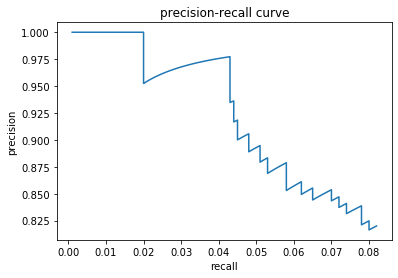

MAP:  0.9256220840647944


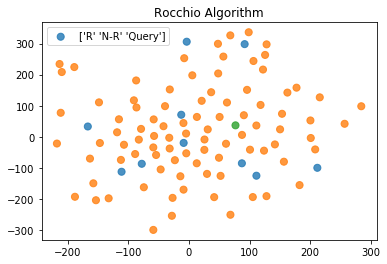

Blue: Relevant, Orange: Irrelevant, Green: Query


In [40]:

query = input("Enter Query: ")
k = int(input("Enter value of K: "))
feed_back_iteration = int(input("give number of iteration for feedback "))
query_vector = create_query_vector(query, tf_idf_invertedindex, vocab)
result_cosine = cosine_retrieval(tf_idf_invertedindex, query_vector, vocab)

kdocs = result_cosine[:k]
MAP = []
for i in range(int(k)):
        print(i,". ",idtoname[kdocs[i]])
        
for i in range(feed_back_iteration):
    print("Iteration: ",i+1)
    kdocs = result_cosine[:k]

    relevantinput = input("Enter index of relevant docs separated by space ")
    relevant_docs_input = relevantinput.split()

    relevant_docs_input = [int(i) for i in relevant_docs_input] 
        
    feedbackdf = tf_idf_invertedindex.loc[:,kdocs]

    reldocs = []
    irrdocs = []
    MAPi = [] 
    for i in relevant_docs_input:
        reldocs.append(kdocs[i])
    for i in kdocs:
        if i not in reldocs:
            irrdocs.append(i)

    query_vector = rocchio_feedback(query_vector,reldocs,irrdocs,feedbackdf)
    result_cosine = cosine_retrieval(tf_idf_invertedindex, query_vector, vocab)
    
    kdocs = result_cosine[:k]
    
    for i in range(int(k)):
        if kdocs[i] in reldocs:
            print(i,". ",idtoname[kdocs[i]], "*")
        else:
            print(i,". ",idtoname[kdocs[i]])

    mapi = plot_pr("talk.politics.misc",kdocs)
    MAPi.append(mapi)
    print("MAP: ",mapi)
    tsne_plot(reldocs, irrdocs, tf_idf_invertedindex, query_vector)
MAP.append(MAPi)

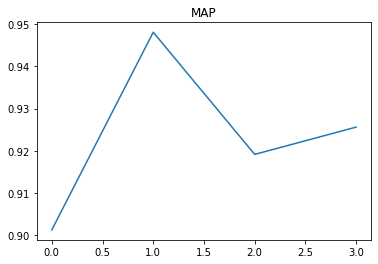

taking avg of above shown map
MAP 0.9235342169463913


In [12]:
map2 = [ 0.9012420912065535,0.9481199717053583,0.9191527208088589,0.9256220840647944 ]
plt.plot(map2)
plt.title("MAP")
plt.show()
avgmap2 = sum(map2)/len(map2)
print("taking avg of above shown map")
print("MAP",avgmap2)

Enter Query: Frequently asked questions on State-of-the-art visualisation tools
Enter value of K: 100
give number of iteration for feedback 4


c:\users\shekh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0 .  ('59324', 'sci.med')
1 .  ('59061', 'sci.med')
2 .  ('58892', 'sci.med')
3 .  ('38962', 'comp.graphics')
4 .  ('37926', 'comp.graphics')
5 .  ('59174', 'sci.med')
6 .  ('59185', 'sci.med')
7 .  ('38354', 'comp.graphics')
8 .  ('179055', 'talk.politics.misc')
9 .  ('61428', 'sci.space')
10 .  ('59493', 'sci.med')
11 .  ('38434', 'comp.graphics')
12 .  ('39495', 'comp.graphics')
13 .  ('60868', 'sci.space')
14 .  ('54130', 'rec.sport.hockey')
15 .  ('60876', 'sci.space')
16 .  ('38496', 'comp.graphics')
17 .  ('38226', 'comp.graphics')
18 .  ('60846', 'sci.space')
19 .  ('38841', 'comp.graphics')
20 .  ('178909', 'talk.politics.misc')
21 .  ('61146', 'sci.space')
22 .  ('61445', 'sci.space')
23 .  ('54047', 'rec.sport.hockey')
24 .  ('179097', 'talk.politics.misc')
25 .  ('52601', 'rec.sport.hockey')
26 .  ('58887', 'sci.med')
27 .  ('60851', 'sci.space')
28 .  ('58074', 'sci.med')
29 .  ('61488', 'sci.space')
30 .  ('178343', 'talk.politics.misc')
31 .  ('59055', 'sci.med')
32 .  (

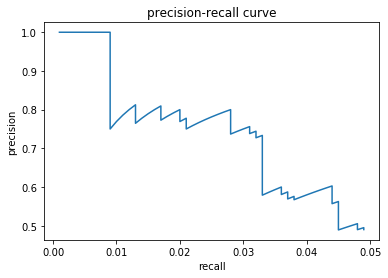

MAP:  0.7493162302937469


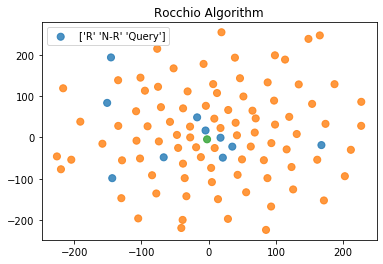

Blue: Relevant, Orange: Irrelevant, Green: Query
Iteration:  2
Enter index of relevant docs separated by space 28 29 30 68 67 72 92 93 94 98


c:\users\shekh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0 .  ('59499', 'sci.med') *
1 .  ('59333', 'sci.med') *
2 .  ('59183', 'sci.med')
3 .  ('59332', 'sci.med') *
4 .  ('59207', 'sci.med') *
5 .  ('59518', 'sci.med') *
6 .  ('59322', 'sci.med')
7 .  ('59034', 'sci.med') *
8 .  ('59304', 'sci.med')
9 .  ('59069', 'sci.med')
10 .  ('59165', 'sci.med')
11 .  ('59234', 'sci.med')
12 .  ('59189', 'sci.med') *
13 .  ('59049', 'sci.med')
14 .  ('59488', 'sci.med')
15 .  ('59395', 'sci.med')
16 .  ('59318', 'sci.med')
17 .  ('59554', 'sci.med')
18 .  ('59338', 'sci.med')
19 .  ('59632', 'sci.med')
20 .  ('59323', 'sci.med')
21 .  ('59548', 'sci.med')
22 .  ('59490', 'sci.med')
23 .  ('59256', 'sci.med')
24 .  ('58578', 'sci.med')
25 .  ('59286', 'sci.med')
26 .  ('59123', 'sci.med')
27 .  ('38403', 'comp.graphics')
28 .  ('39078', 'comp.graphics')
29 .  ('39638', 'comp.graphics')
30 .  ('178786', 'talk.politics.misc')
31 .  ('59527', 'sci.med')
32 .  ('59504', 'sci.med')
33 .  ('59459', 'sci.med')
34 .  ('59284', 'sci.med')
35 .  ('59044', 'sci.

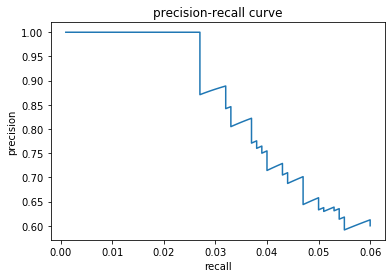

MAP:  0.8488693653258905


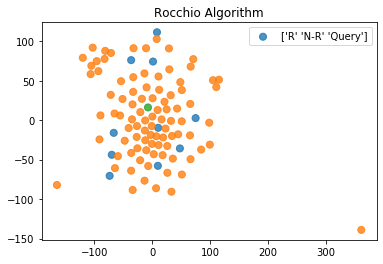

Blue: Relevant, Orange: Irrelevant, Green: Query
Iteration:  3
Enter index of relevant docs separated by space 56 57 58 64 65 66 93 94 95 13


c:\users\shekh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0 .  ('59499', 'sci.med')
1 .  ('59183', 'sci.med')
2 .  ('59069', 'sci.med')
3 .  ('59049', 'sci.med') *
4 .  ('59034', 'sci.med')
5 .  ('59333', 'sci.med')
6 .  ('59332', 'sci.med')
7 .  ('59518', 'sci.med')
8 .  ('58569', 'sci.med') *
9 .  ('59304', 'sci.med')
10 .  ('59234', 'sci.med')
11 .  ('59490', 'sci.med')
12 .  ('59165', 'sci.med')
13 .  ('58984', 'sci.med') *
14 .  ('59207', 'sci.med')
15 .  ('59488', 'sci.med')
16 .  ('59395', 'sci.med')
17 .  ('59256', 'sci.med')
18 .  ('59202', 'sci.med') *
19 .  ('59189', 'sci.med')
20 .  ('59322', 'sci.med')
21 .  ('59554', 'sci.med')
22 .  ('58882', 'sci.med') *
23 .  ('58109', 'sci.med') *
24 .  ('59203', 'sci.med') *
25 .  ('58578', 'sci.med')
26 .  ('59338', 'sci.med')
27 .  ('38403', 'comp.graphics')
28 .  ('59632', 'sci.med')
29 .  ('39078', 'comp.graphics')
30 .  ('39638', 'comp.graphics')
31 .  ('59318', 'sci.med')
32 .  ('59271', 'sci.med') *
33 .  ('59447', 'sci.med') *
34 .  ('58897', 'sci.med')
35 .  ('59548', 'sci.med')
36

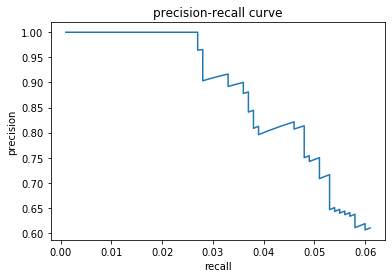

MAP:  0.8818993456597328


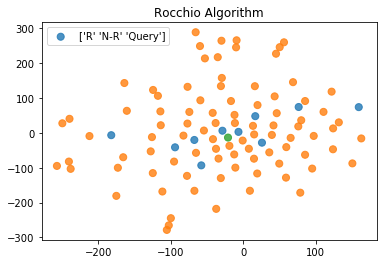

Blue: Relevant, Orange: Irrelevant, Green: Query
Iteration:  4
Enter index of relevant docs separated by space 4 5 6 7 37 38 39 49 50 51


c:\users\shekh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0 .  ('59183', 'sci.med')
1 .  ('59333', 'sci.med') *
2 .  ('59034', 'sci.med') *
3 .  ('59069', 'sci.med')
4 .  ('59499', 'sci.med')
5 .  ('59332', 'sci.med') *
6 .  ('59049', 'sci.med')
7 .  ('59304', 'sci.med')
8 .  ('59322', 'sci.med')
9 .  ('59518', 'sci.med') *
10 .  ('59123', 'sci.med') *
11 .  ('59165', 'sci.med')
12 .  ('59323', 'sci.med') *
13 .  ('59395', 'sci.med')
14 .  ('59488', 'sci.med')
15 .  ('58910', 'sci.med') *
16 .  ('59632', 'sci.med')
17 .  ('59207', 'sci.med')
18 .  ('59554', 'sci.med')
19 .  ('59490', 'sci.med')
20 .  ('59318', 'sci.med')
21 .  ('59637', 'sci.med') *
22 .  ('59338', 'sci.med')
23 .  ('59234', 'sci.med')
24 .  ('59286', 'sci.med')
25 .  ('59459', 'sci.med') *
26 .  ('59256', 'sci.med')
27 .  ('59202', 'sci.med')
28 .  ('58578', 'sci.med')
29 .  ('58569', 'sci.med')
30 .  ('58984', 'sci.med')
31 .  ('38403', 'comp.graphics')
32 .  ('39078', 'comp.graphics')
33 .  ('39638', 'comp.graphics')
34 .  ('59203', 'sci.med')
35 .  ('178786', 'talk.politi

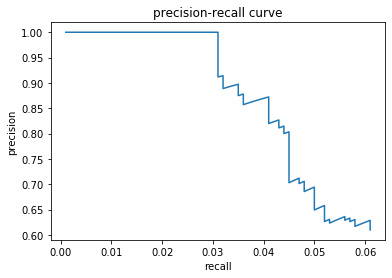

MAP:  0.8781370564100244


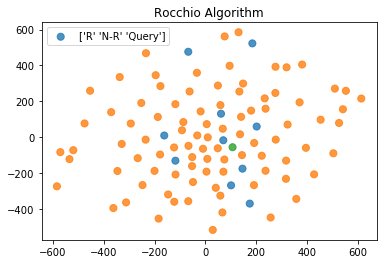

Blue: Relevant, Orange: Irrelevant, Green: Query


In [51]:

query = input("Enter Query: ")
k = int(input("Enter value of K: "))
feed_back_iteration = int(input("give number of iteration for feedback "))
query_vector = create_query_vector(query, tf_idf_invertedindex, vocab)
result_cosine = cosine_retrieval(tf_idf_invertedindex, query_vector, vocab)

kdocs = result_cosine[:k]
MAP = []
for i in range(int(k)):
        print(i,". ",idtoname[kdocs[i]])
        
for i in range(feed_back_iteration):
    print("Iteration: ",i+1)
    kdocs = result_cosine[:k]

    relevantinput = input("Enter index of relevant docs separated by space ")
    relevant_docs_input = relevantinput.split()

    relevant_docs_input = [int(i) for i in relevant_docs_input] 
        
    feedbackdf = tf_idf_invertedindex.loc[:,kdocs]

    reldocs = []
    irrdocs = []
    MAPi = [] 
    for i in relevant_docs_input:
        reldocs.append(kdocs[i])
    for i in kdocs:
        if i not in reldocs:
            irrdocs.append(i)

    query_vector = rocchio_feedback(query_vector,reldocs,irrdocs,feedbackdf)
    result_cosine = cosine_retrieval(tf_idf_invertedindex, query_vector, vocab)
    
    kdocs = result_cosine[:k]
    
    for i in range(int(k)):
        if kdocs[i] in reldocs:
            print(i,". ",idtoname[kdocs[i]], "*")
        else:
            print(i,". ",idtoname[kdocs[i]])

    mapi = plot_pr("sci.med",kdocs)
    MAPi.append(mapi)
    print("MAP: ",mapi)
    tsne_plot(reldocs, irrdocs, tf_idf_invertedindex, query_vector)
MAP.append(MAPi)

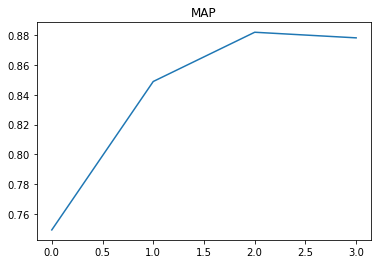

taking avg of above shown map
MAP 0.8395554994223487


In [11]:
map3 = [ 0.7493162302937469,0.8488693653258905,0.8818993456597328,0.8781370564100244 ]
plt.plot(map3)
plt.title("MAP")
plt.show()
avgmap3 = sum(map3)/len(map3)
print("taking avg of above shown map")
print("MAP",avgmap3)